In [1]:
!pip install optuna

     |████████████████████████████████| 308 kB 29.0 MB/s 
     |████████████████████████████████| 81 kB 12.3 MB/s 
     |████████████████████████████████| 210 kB 68.1 MB/s 
     |████████████████████████████████| 78 kB 9.3 MB/s 
     |████████████████████████████████| 150 kB 70.9 MB/s 
     |████████████████████████████████| 49 kB 7.8 MB/s 
     |████████████████████████████████| 113 kB 70.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=360d48d4be6b7da6f9c703753f5a1fefd6d6739da80c57c31f15cfbe90df587a
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.feature_selection import SelectFromModel
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# getting data from source
df_genomicMatrix=pd.read_csv('https://ucsc-public-main-xena-hub.s3.us-east-1.amazonaws.com/download/miller2005_public%2Fmiller2005_genomicMatrix.gz',delimiter='\t',header=None)
df_clinicalMatrix=pd.read_csv('https://ucsc-public-main-xena-hub.s3.us-east-1.amazonaws.com/download/miller2005_public%2Fmiller2005_public_clinicalMatrix.gz',delimiter='\t')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251) ha

In [4]:
# first few rows of clinical matrix
df_clinicalMatrix.head(10)

,sampleID,AgeAtDiagnosis,DLDAerror,DSS,DSS.time,ERstatus,EistonHistologicGrade,LymphNodeStatus,PgRstatus,TumorSize,_INTEGRATION,_PATIENT,p53DLDAclassResult,p53mutant,_GENOMIC_ID_miller2005
0,X100B08,68,No,AliveOrCensored,12.0,ER+,G1,LN-,PgR-,9.0,X100B08,X100B08,WT-like,p53-,X100B08
1,X101B88,40,No,AliveOrCensored,12.0,ER-,G3,LN-,PgR-,12.0,X101B88,X101B88,MT-like,p53+,X101B88
2,X102B06,51,No,AliveOrCensored,12.0,ER+,G3,LN-,PgR+,26.0,X102B06,X102B06,MT-like,p53+,X102B06
3,X103B41,52,Yes,NaN,NaN,ER-,G3,LN+,PgR-,22.0,X103B41,X103B41,MT-like,p53-,X103B41
4,X104B91,80,Yes,AliveOrCensored,4.0,ER+,G3,NaN,PgR+,24.0,X104B91,X104B91,WT-like,p53+,X104B91
5,X105B13,46,No,AliveOrCensored,12.0,ER+,G1,LN-,PgR+,13.0,X105B13,X105B13,WT-like,p53-,X105B13
6,X106B55,37,No,DeathFromCancer,7.0,ER+,G1,LN-,PgR+,60.0,X106B55,X106B55,WT-like,p53-,X106B55
7,X10B88,70,No,AliveOrCensored,11.0,ER+,G1,LN-,PgR+,50.0,X10B88,X10B88,WT-like,p53-,X10B88
8,X110B34,74,No,AliveOrCensored,12.0,ER+,G2,LN-,PgR+,20.0,X110B34,X110B34,MT-like,p53+,X110B34
9,X111B51,41,No,DeathFromCancer,7.0,ER+,G3,LN-,PgR+,33.0,X111B51,X111B51,MT-like,p53+,X111B51


In [5]:
# Column names for clinical matrix
df_clinicalMatrix.columns

Index(['sampleID', 'AgeAtDiagnosis', 'DLDAerror', 'DSS', 'DSS.time',
       'ERstatus', 'EistonHistologicGrade', 'LymphNodeStatus', 'PgRstatus',
       'TumorSize', '_INTEGRATION', '_PATIENT', 'p53DLDAclassResult',
       'p53mutant', '_GENOMIC_ID_miller2005'],
      dtype='object')

In [6]:
# categorical features in the clinical matrix
cat_features = [column for column in df_clinicalMatrix.columns if df_clinicalMatrix[column].dtypes=='O']
df_clinicalMatrix[cat_features].head(5)

,sampleID,DLDAerror,DSS,ERstatus,EistonHistologicGrade,LymphNodeStatus,PgRstatus,_INTEGRATION,_PATIENT,p53DLDAclassResult,p53mutant,_GENOMIC_ID_miller2005
0,X100B08,No,AliveOrCensored,ER+,G1,LN-,PgR-,X100B08,X100B08,WT-like,p53-,X100B08
1,X101B88,No,AliveOrCensored,ER-,G3,LN-,PgR-,X101B88,X101B88,MT-like,p53+,X101B88
2,X102B06,No,AliveOrCensored,ER+,G3,LN-,PgR+,X102B06,X102B06,MT-like,p53+,X102B06
3,X103B41,Yes,NaN,ER-,G3,LN+,PgR-,X103B41,X103B41,MT-like,p53-,X103B41
4,X104B91,Yes,AliveOrCensored,ER+,G3,NaN,PgR+,X104B91,X104B91,WT-like,p53+,X104B91


In [7]:
# numerical features in the clinical matrix
num_features = [column for column in df_clinicalMatrix.columns if df_clinicalMatrix[column].dtypes!='O']
df_clinicalMatrix[num_features].head(5)

,AgeAtDiagnosis,DSS.time,TumorSize
0,68,12.0,9.0
1,40,12.0,12.0
2,51,12.0,26.0
3,52,NaN,22.0
4,80,4.0,24.0


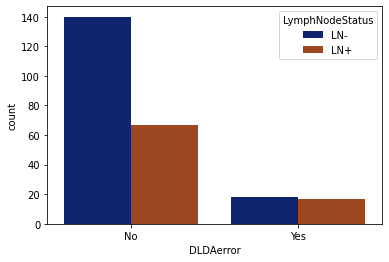

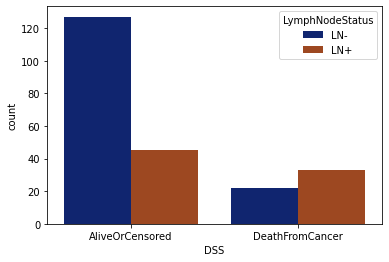

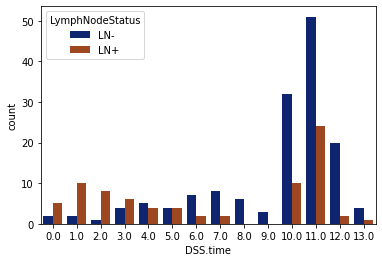

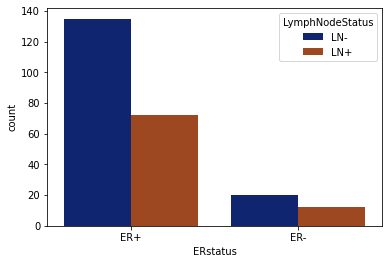

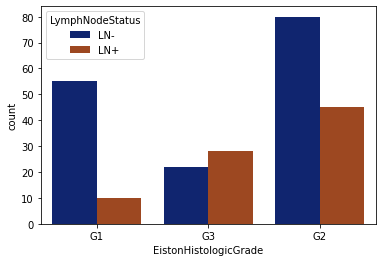

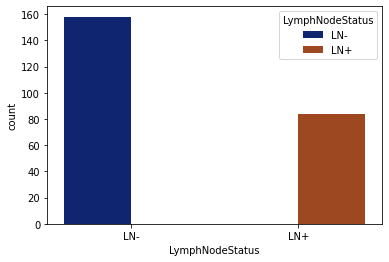

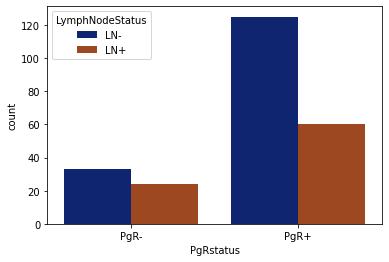

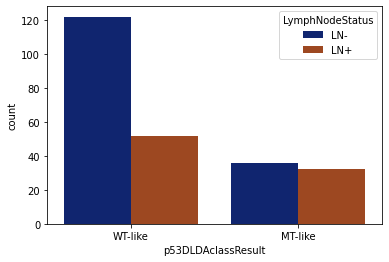

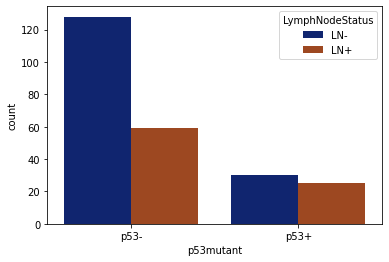

In [8]:
# countplots for categorical data with respect to 'LymphNodeStatus'
df_clinmat = df_clinicalMatrix.drop(['sampleID','AgeAtDiagnosis','TumorSize','_INTEGRATION','_PATIENT','_GENOMIC_ID_miller2005'],axis=1)
for x in df_clinmat.columns:
    sns.countplot(data= df_clinmat,x=df_clinmat[x],hue=df_clinmat['LymphNodeStatus'],palette='dark')
    plt.show()

In [9]:
# first few rows of genomic matrix
df_genomicMatrix.head(10)

,0,1,2,3,4,5,6,7,8,9,...,242,243,244,245,246,247,248,249,250,251
0,probe,X100B08,X101B88,X102B06,X103B41,X104B91,X105B13,X106B55,X10B88,X110B34,...,X85A03,X86A40,X87A79,X88A67,X8B87,X90A63,X94A16,X96A21,X99A50,X9B52
1,211050_x_at,-0.60609845997949,-0.71211732736651,-0.24902371657542,0.47339419538929,-0.54907184258026,-0.3092005016715,0.41897323719004,-0.3946572303695,-0.47251557515557,...,0.19425738895826,-0.0147835375762102,0.13407539167209,-0.19990245782577,0.11891965170859,-0.37927029343351,0.82007590513398,-0.0455767367670501,-0.0245526540187702,0.27066630092569
2,220399_at,0.297761884637424,0.108554028539094,0.529915688630775,-0.0236977596184555,-0.240674552924416,-0.186094550508416,0.00280455771169397,-0.131805918000736,0.113294687596224,...,0.158997493199424,0.228584615788685,-1.61824983812591,-0.237390400226426,0.228422630263264,-0.433716710549096,-1.76092467281198,0.290774879921944,0.248706789784914,-0.0227919448987057
3,202115_s_at,-0.0207199586993729,-0.329812842420013,-0.455559869614984,0.335866503578156,0.0914735642808466,-0.0649335936114834,0.232192293522567,-0.0245333551689031,0.390957101123317,...,0.611860013300097,0.303447871810647,0.0735930672214167,-0.082834904637803,0.133630190202147,0.0553951474851369,0.0711540480339563,-0.114437082375583,0.242832779585116,0.218242406811207
4,224501_at,0.0191163830257484,-0.508559867759712,0.0562016961050977,-0.0112785620922615,0.189045651599998,0.696562269810068,0.192981870643838,-0.319990873927932,-0.243858578920162,...,0.209863932679728,0.215091978389048,-0.323448141350642,-0.0203078647708521,0.214314624350358,0.212822716079898,0.368002424465348,0.207985730041758,0.267992659684308,0.791908891893848
5,227347_x_at,0.217003285274825,0.750268555716166,0.469504094265635,-0.182405554283685,-0.472259746631345,0.294003049170574,0.147631658679885,0.462857150607994,0.781625005612315,...,-0.792750352948505,0.744522780941135,0.156746782941595,-0.0604454092963254,0.107038907434855,-0.192823561730845,0.0307527555541549,-0.463568592211125,0.116093520978945,-0.142528684288885
6,205483_s_at,-0.959765619734105,-0.739373617253365,0.436695502974866,0.913890761259296,1.18484495173342,-0.921591248427505,-0.976086516126244,1.81810520319521,-0.723100883245385,...,-1.11561706495908,-1.75963015795501,0.355280087728865,0.881458469512495,-0.714931953437455,0.971320638022425,1.83952061250142,-0.695891246645205,-1.02142827267055,1.35853694226627
7,212283_at,0.31905965380238,-0.63507596067365,0.253222377924609,0.134584773097739,0.204097424289389,-1.48858656175022,0.124965967004189,-0.399400768147571,-1.10388472055312,...,-0.0234020299288709,-0.785423593070711,-0.148167985995971,-0.0653804748145212,0.670274920597399,-0.620541625136491,-0.131310737024201,-0.275498863350731,-0.333262132498781,0.217372783731449
8,212285_s_at,0.26743053282687,0.404148351178069,0.236893737236249,0.46841163348552,0.397235706101899,0.47611631765845,0.405963629525349,0.0941344988476995,0.373420130159879,...,0.0205554728932693,-0.606536417971721,-0.162472454063082,-0.520093286319691,0.127405316667399,-0.30007531133036,-0.134719368061351,-0.61724686479563,-0.00359567394769122,-0.083492616828881
9,217419_x_at,0.0546245393746343,0.553476301226864,0.263843536673264,0.508556696455114,0.107319891585904,0.844849143201444,0.0171650830981847,0.264637970710144,0.493297784508725,...,0.018747293370545,-1.03597918814879,-0.0122102766741659,-0.563183591738616,0.252069009905044,-0.227527908675295,-0.0885185694443251,-0.927063458578016,-0.0206992687985554,-0.166205147103785


In [10]:
# transpose of genomic matrix data 
df_genomicMatrix_t=df_genomicMatrix.T

In [11]:
# first few rows of the transposed matrix
df_genomicMatrix_t.head(10)

,0,1,2,3,4,5,6,7,8,9,...,24702,24703,24704,24705,24706,24707,24708,24709,24710,24711
0,probe,211050_x_at,220399_at,202115_s_at,224501_at,227347_x_at,205483_s_at,212283_at,212285_s_at,217419_x_at,...,216922_x_at,208331_at,211461_at,232402_at,207647_at,207646_s_at,207916_at,202829_s_at,214950_at,208164_s_at
1,X100B08,-0.60609845997949,0.297761884637424,-0.0207199586993729,0.0191163830257484,0.217003285274825,-0.959765619734105,0.31905965380238,0.26743053282687,0.0546245393746343,...,0.585269,0.677886,0.294886,0.334739,-0.922423,0.525822,0.65593,-0.373383,0.533709,0.9551
2,X101B88,-0.71211732736651,0.108554028539094,-0.329812842420013,-0.508559867759712,0.750268555716166,-0.739373617253365,-0.63507596067365,0.404148351178069,0.553476301226864,...,0.34349,-0.37717,-0.146836,-0.027103,0.108189,-0.108456,0.800626,0.047387,-0.630866,0.550008
3,X102B06,-0.24902371657542,0.529915688630775,-0.455559869614984,0.0562016961050977,0.469504094265635,0.436695502974866,0.253222377924609,0.236893737236249,0.263843536673264,...,-1.192292,-0.264924,-0.403073,-0.273291,0.408303,0.256424,0.052404,-0.076766,0.170939,-0.016254
4,X103B41,0.47339419538929,-0.0236977596184555,0.335866503578156,-0.0112785620922615,-0.182405554283685,0.913890761259296,0.134584773097739,0.46841163348552,0.508556696455114,...,0.233813,-0.182134,-0.132613,0.314508,0.147834,-0.766659,-1.517961,0.487872,0.394624,0.440938
5,X104B91,-0.54907184258026,-0.240674552924416,0.0914735642808466,0.189045651599998,-0.472259746631345,1.18484495173342,0.204097424289389,0.397235706101899,0.107319891585904,...,-0.063716,-0.051118,-0.149773,-0.304061,-1.229899,-0.000545,0.574513,0.597032,0.196972,0.120323
6,X105B13,-0.3092005016715,-0.186094550508416,-0.0649335936114834,0.696562269810068,0.294003049170574,-0.921591248427505,-1.48858656175022,0.47611631765845,0.844849143201444,...,0.030546,-0.375298,-0.126434,-0.522002,-0.202992,0.404424,-1.47332,-0.123029,0.186654,0.001976
7,X106B55,0.41897323719004,0.00280455771169397,0.232192293522567,0.192981870643838,0.147631658679885,-0.976086516126244,0.124965967004189,0.405963629525349,0.0171650830981847,...,-0.004474,0.35375,0.617883,-0.305822,1.063415,0.286753,0.049589,-0.303107,0.092048,-0.540364
8,X10B88,-0.3946572303695,-0.131805918000736,-0.0245333551689031,-0.319990873927932,0.462857150607994,1.81810520319521,-0.399400768147571,0.0941344988476995,0.264637970710144,...,-0.622247,-0.626365,0.065377,-0.369323,-0.35414,-0.262451,-1.402688,0.395614,-0.111405,-1.622608
9,X110B34,-0.47251557515557,0.113294687596224,0.390957101123317,-0.243858578920162,0.781625005612315,-0.723100883245385,-1.10388472055312,0.373420130159879,0.493297784508725,...,0.094237,0.090609,-0.379683,-0.637746,-1.147669,-0.804886,-1.236389,0.370725,0.019525,-0.091616


In [12]:
df_genomicMatrix_t.columns = df_genomicMatrix_t.iloc[0] # converting first row into column names 
df_genomicMatrix_t=df_genomicMatrix_t.iloc[1:] # deleting first row due to duplicate

In [13]:
df_genomicMatrix_t.rename(columns={'probe': 'sampleID'}, inplace=True) # renaming first column to make a join with the clinicalMatrix dataframe

In [14]:
df_genomicMatrix_t.columns

Index(['sampleID', '211050_x_at', '220399_at', '202115_s_at', '224501_at',
       '227347_x_at', '205483_s_at', '212283_at', '212285_s_at', '217419_x_at',
       ...
       '216922_x_at', '208331_at', '211461_at', '232402_at', '207647_at',
       '207646_s_at', '207916_at', '202829_s_at', '214950_at', '208164_s_at'],
      dtype='object', name=0, length=24712)

In [15]:
# joining the two dataframes
df_inner = pd.merge(df_genomicMatrix_t, df_clinicalMatrix, on='sampleID',how='inner')
df_inner.head(5)

,sampleID,211050_x_at,220399_at,202115_s_at,224501_at,227347_x_at,205483_s_at,212283_at,212285_s_at,217419_x_at,...,ERstatus,EistonHistologicGrade,LymphNodeStatus,PgRstatus,TumorSize,_INTEGRATION,_PATIENT,p53DLDAclassResult,p53mutant,_GENOMIC_ID_miller2005
0,X100B08,-0.60609845997949,0.297761884637424,-0.0207199586993729,0.0191163830257484,0.217003285274825,-0.959765619734105,0.31905965380238,0.26743053282687,0.0546245393746343,...,ER+,G1,LN-,PgR-,9.0,X100B08,X100B08,WT-like,p53-,X100B08
1,X101B88,-0.71211732736651,0.108554028539094,-0.329812842420013,-0.508559867759712,0.750268555716166,-0.739373617253365,-0.63507596067365,0.404148351178069,0.553476301226864,...,ER-,G3,LN-,PgR-,12.0,X101B88,X101B88,MT-like,p53+,X101B88
2,X102B06,-0.24902371657542,0.529915688630775,-0.455559869614984,0.0562016961050977,0.469504094265635,0.436695502974866,0.253222377924609,0.236893737236249,0.263843536673264,...,ER+,G3,LN-,PgR+,26.0,X102B06,X102B06,MT-like,p53+,X102B06
3,X103B41,0.47339419538929,-0.0236977596184555,0.335866503578156,-0.0112785620922615,-0.182405554283685,0.913890761259296,0.134584773097739,0.46841163348552,0.508556696455114,...,ER-,G3,LN+,PgR-,22.0,X103B41,X103B41,MT-like,p53-,X103B41
4,X104B91,-0.54907184258026,-0.240674552924416,0.0914735642808466,0.189045651599998,-0.472259746631345,1.18484495173342,0.204097424289389,0.397235706101899,0.107319891585904,...,ER+,G3,NaN,PgR+,24.0,X104B91,X104B91,WT-like,p53+,X104B91


In [16]:
df_inner.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251 entries, 0 to 250
Columns: 24726 entries, sampleID to _GENOMIC_ID_miller2005
dtypes: float64(2), int64(1), object(24723)
memory usage: 47.4+ MB


In [17]:
# dropping null and duplicate values
df_inner=df_inner.dropna()
df_inner=df_inner.drop_duplicates()

In [18]:
# dropping other columns to predict only the 'LymphNodeStatus'
df_inner_E = df_inner.drop(columns=['sampleID', 'AgeAtDiagnosis', 'DLDAerror', 'DSS', 'DSS.time',
       'ERstatus', 'TumorSize', 'PgRstatus',
       'EistonHistologicGrade', '_INTEGRATION', '_PATIENT', 'p53DLDAclassResult',
       'p53mutant', '_GENOMIC_ID_miller2005'])

In [19]:
print(df_inner_E['LymphNodeStatus'].value_counts().sort_values(ascending=False))

LN-    145
LN+     77
Name: LymphNodeStatus, dtype: int64


In [20]:
# Splitting data into train and test
X=df_inner_E.drop(columns=['LymphNodeStatus'],axis=1) 
X=X.apply(pd.to_numeric) #convert data to numeric as it is object type
y=df_inner['LymphNodeStatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10000, n_jobs=-1, random_state=0)

In [22]:
# Create a selector object that will use the random forest classifier to identify features that have an importance of more than 4.0e-05
sfm = SelectFromModel(clf, threshold=4.0e-05)

# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=10000, n_jobs=-1,
                                                 random_state=0),
                threshold=4e-05)

In [23]:
feature_idx = sfm.get_support(indices='True')
feature_name = X.columns[feature_idx]

In [25]:
# Transform the data to create a new dataset containing only the most important features
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [24]:
feature_name

Index(['237744_at', '221972_s_at', '212401_s_at', '208918_s_at', '208919_s_at',
       '213607_x_at', '200744_s_at', '200746_s_at', '215788_at', '216781_at',
       ...
       '266_s_at', '208651_x_at', '209772_s_at', '216842_x_at', '208332_at',
       '208281_x_at', '207647_at', '207916_at', '202829_s_at', '208164_s_at'],
      dtype='object', length=7352)

In [26]:
X_important_train.shape

(148, 7352)

In [28]:
y_train= pd.get_dummies(y_train)
y_test= pd.get_dummies(y_test)